## Audio Classification for Language Identification
#### Objective: Train a model that can classify audio clips into one of three languages: Uzbek, Russian, or English.
#### Input: Audio Clip Output: Probabilities for the three classes (uz, ru, en)

Author: Davron Ikhmatullaev

This is the notebook that used for train the model 

Necessary libs:

In [ ]:
# !pip install transformers -U
# !pip install datasets
# !pip install torch
# !pip install evaluate>=0.30
# !pip install environs
# !pip install accelerate -U

Checking hardware

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Mar  7 12:13:48 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   39C    P8              4W /   60W |      40MiB /   4096MiB |     38%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch

torch.cuda.is_available()

True

## Work with Data

#### Data loading

Load CommonVoice datasets (uzbek, russian, english) from huggingface in the streaming mode.

In [3]:
from datasets import load_dataset
from environs import Env

env = Env()
env.read_env('./.env')


common_voice_train_uz = load_dataset("mozilla-foundation/common_voice_16_1", "uz", split='train', trust_remote_code=True, token=env('HUGGING_TOKEN'), streaming=True)
common_voice_train_ru = load_dataset("mozilla-foundation/common_voice_16_1", "ru", split='train', trust_remote_code=True, token=env('HUGGING_TOKEN'), streaming=True)
common_voice_train_en = load_dataset("mozilla-foundation/common_voice_16_1", "en", split='train', trust_remote_code=True, token=env('HUGGING_TOKEN'), streaming=True)


common_voice_valid_uz = load_dataset("mozilla-foundation/common_voice_16_1", "uz", split='validation', trust_remote_code=True, token=env('HUGGING_TOKEN'), streaming=True)
common_voice_valid_ru = load_dataset("mozilla-foundation/common_voice_16_1", "ru", split='validation', trust_remote_code=True, token=env('HUGGING_TOKEN'), streaming=True)
common_voice_valid_en = load_dataset("mozilla-foundation/common_voice_16_1", "en", split='validation', trust_remote_code=True, token=env('HUGGING_TOKEN'), streaming=True)

common_voice_test_uz = load_dataset("mozilla-foundation/common_voice_16_1", "uz", split='test', trust_remote_code=True, token=env('HUGGING_TOKEN'), streaming=True)
common_voice_test_ru = load_dataset("mozilla-foundation/common_voice_16_1", "ru", split='test', trust_remote_code=True, token=env('HUGGING_TOKEN'), streaming=True)
common_voice_test_en = load_dataset("mozilla-foundation/common_voice_16_1", "en", split='test', trust_remote_code=True, token=env('HUGGING_TOKEN'), streaming=True)

Time for pick size of training, validation and test sets. Let's split as 80-10-10.

In [4]:
seed = 42

train_size = 8000
valid_size = 1000

common_voice_train_uz = common_voice_train_uz.take(train_size).shuffle(seed=seed, buffer_size=train_size)
common_voice_train_ru = common_voice_train_ru.take(train_size).shuffle(seed=seed, buffer_size=train_size)
common_voice_train_en = common_voice_train_en.take(train_size).shuffle(seed=seed, buffer_size=train_size)

common_voice_valid_uz = common_voice_valid_uz.take(valid_size).shuffle(seed=seed, buffer_size=valid_size)
common_voice_valid_ru = common_voice_valid_ru.take(valid_size).shuffle(seed=seed, buffer_size=valid_size)
common_voice_valid_en = common_voice_valid_en.take(valid_size).shuffle(seed=seed, buffer_size=valid_size)

Concatenate Iterable datasets into one and store train and validation datasets in dict. So final datasets size will be 24000 - 3000 - 3000 rows, for training, validation and testing accordingly.

In [5]:
from datasets import concatenate_datasets, IterableDatasetDict


common_voice = IterableDatasetDict()
common_voice['train'] = concatenate_datasets([common_voice_train_uz, common_voice_train_ru, common_voice_train_en])
common_voice['eval'] = concatenate_datasets([common_voice_valid_uz, common_voice_valid_ru, common_voice_valid_en])

Shuffle concatenated datasets again.

In [6]:
common_voice['train'] = common_voice['train'].shuffle(seed=seed, buffer_size=train_size * 3)
common_voice['eval'] = common_voice['eval'].shuffle(seed=seed, buffer_size=valid_size * 3)

In [30]:
import pandas as pd


uz_data = [8000, 1000, 1000]
ru_data = [8000, 1000, 1000]
en_data = [8000, 1000, 1000]
total_data = [24000, 3000, 3000]

df = pd.DataFrame([uz_data, ru_data, en_data, total_data], columns=['train', 'valid', 'test'], index=['Uzbek', 'Russian', 'English', 'Total'])
display(df)

,train,valid,test
Uzbek,8000,1000,1000
Russian,8000,1000,1000
English,8000,1000,1000
Total,24000,3000,3000


#### Data preparation

Remove unneсessary columns

In [7]:
common_voice = common_voice.remove_columns(["accent", 'sentence', "age", "client_id", "down_votes", "gender",  "path", "segment", "up_votes"])

Checking the consistency of datasets

In [11]:
count = 0 
for row in common_voice['eval']:
    display(row)
    count +=1 
    if count > 4:
        break

Reading metadata...: 12131it [00:01, 10145.47it/s]
Reading metadata...: 10198it [00:01, 9365.95it/s]
Reading metadata...: 16390it [00:01, 10522.08it/s]


{'audio': {'path': None,
  'array': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.10351562e-05, 1.22070312e-04, 3.05175781e-05]),
  'sampling_rate': 48000},
 'locale': 'en',
 'variant': ''}

{'audio': {'path': None,
  'array': array([0., 0., 0., ..., 0., 0., 0.]),
  'sampling_rate': 48000},
 'locale': 'uz',
 'variant': ''}

{'audio': {'path': None,
  'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -3.05175781e-05, -3.05175781e-05,  0.00000000e+00]),
  'sampling_rate': 48000},
 'locale': 'ru',
 'variant': ''}

{'audio': {'path': None,
  'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          3.05175781e-05,  0.00000000e+00, -3.05175781e-05]),
  'sampling_rate': 48000},
 'locale': 'uz',
 'variant': ''}

{'audio': {'path': None,
  'array': array([0., 0., 0., ..., 0., 0., 0.]),
  'sampling_rate': 48000},
 'locale': 'en',
 'variant': ''}

Yeah. great. We got shuffled data. But since our input audio is sampled at 48kHz, we need to downsample it to 16kHz prior to passing it to the Whisper feature extractor, 16kHz being the sampling rate expected by the Whisper model:

In [8]:
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

Check audio rate

In [28]:
next(iter(common_voice['train']))

Reading metadata...: 48452it [00:05, 9529.70it/s] 
Reading metadata...: 26359it [00:03, 8359.81it/s]
Reading metadata...: 1090061it [01:24, 12910.07it/s]


{'audio': {'path': None,
  'array': array([0., 0., 0., ..., 0., 0., 0.]),
  'sampling_rate': 48000},
 'locale': 'ru',
 'variant': ''}

#### Feature extractor

The Whisper feature extractor performs two operations:

Pads / truncates the audio inputs to 30s: any audio inputs shorter than 30s are padded to 30s with silence (zeros), and those longer that 30s are truncated to 30s
Converts the audio inputs to log-Mel spectrogram input features, a visual representation of the audio and the form of the input expected by the Whisper model

In [9]:
from transformers import WhisperFeatureExtractor


feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")

In [10]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array 
    batch["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

    return batch

In [11]:
common_voice = common_voice.map(prepare_dataset, batched=False, remove_columns=['audio'])

#### Labels encoding

Let's encode the output labels (lang-id) to the numbers. We will create two dictionaries to convert id2label and vice versa.

In [12]:
languages = ['uz', 'ru', 'en']

id2label = {idx: languages[idx] for idx in range(len(languages))}
label2id = {v: k for k, v in id2label.items()}
label2id

{'uz': 0, 'ru': 1, 'en': 2}

In [13]:
def encode_labels(example):
    """Map string labels to integers."""
    example["labels"] = label2id[example["locale"]]
    return example

In [14]:
common_voice = common_voice.map(encode_labels, batched=False)

## Training model and Evaluation

#### Defining Data collator

In [15]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorForClassification:
    feature_extractor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.feature_extractor.pad(input_features, return_tensors="pt")

        # # get labels
        labels = [feature["labels"] for feature in features]
        batch["labels"] = torch.tensor(labels)

        return batch

In [16]:
data_collator = DataCollatorForClassification(feature_extractor=feature_extractor)

#### Load a pre-trained checkpoint of the Whisper small model.

Loading model and define the config parameters

In [17]:
from transformers import AutoModelForAudioClassification

device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForAudioClassification.from_pretrained(
  "openai/whisper-small", num_labels=len(languages), id2label=id2label, label2id=label2id
).to(device)

Some weights of WhisperForAudioClassification were not initialized from the model checkpoint at openai/whisper-small and are newly initialized: ['model.classifier.bias', 'model.classifier.weight', 'model.projector.bias', 'model.projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Evaluation metrics

In [18]:
import evaluate

accuracy = evaluate.load("accuracy")

In [19]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

# def compute_metrics(eval_pred):
#     predictions = np.argmax(eval_pred.predictions, axis=1)
#     return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

def compute_metrics(pred):
    """Custom metric to be used during training."""
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)  # Accuracy
    f1 = f1_score(labels, preds, average="weighted")  # F1-score
    return {
        "accuracy": acc,
        "f1": f1
        }

#### Define the Training Configuration

It's crucial to choose right numbers of steps for evaluation, saving and max steps. Because we are using iterable dataset, there are some drawbacks, such as Trainer think max steps == 1 epoch. That's why in the reports we will have some mistakes at epoch column. 

What about batch size?! After some iteration it was calculated, that my GPU (3050Ti Mobile) could handle only 2 batches at the same time. But we can increase batch size by implementing gradient_accumulation_steps. That's why our total batches size will be 8. We should start evaluation after each epoch, thats why 1 epoch will end at batch_size * steps. Our training dataset size is 8000 * 3 = 24000, So we should choose 24000 / 8 = 3000 as the epoch end and evaluation start time. And for 3 epochs cycle max_steps will be 3 * 3000 = 9000

In [20]:
from transformers import TrainingArguments


training_args = TrainingArguments(
    output_dir="whisper-small-uz-en-ru-lang-id",
    evaluation_strategy="steps",
    save_strategy="steps",
    max_steps=9000,
    eval_steps=3000,
    save_steps=3000,
    num_train_epochs=3,
    logging_steps=20,
    learning_rate=3e-5,
    gradient_accumulation_steps=4,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    hub_token=env('HUGGING_WRITE'),
    push_to_hub=True,
    fp16=True,

)


In [21]:
from transformers import Trainer

trainer = Trainer(
  model,
  training_args,
  compute_metrics=compute_metrics,
  train_dataset=common_voice['train'],
  eval_dataset=common_voice['eval'],
  data_collator=data_collator,
  tokenizer=feature_extractor,
)

#### Training

In [22]:
torch.cuda.empty_cache()

In [23]:
!nvidia-smi

Thu Mar  7 12:18:12 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0  On |                  N/A |
| N/A   38C    P8              3W /   60W |     507MiB /   4096MiB |     32%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
trainer.train()

  0%|          | 0/9000 [00:00<?, ?it/s]

Reading metadata...: 48452it [00:10, 4491.57it/s]
Reading metadata...: 26359it [00:05, 4982.65it/s]
Reading metadata...: 1090061it [03:14, 5594.78it/s] 


{'loss': 1.0974, 'grad_norm': 5.340683937072754, 'learning_rate': 6.666666666666667e-07, 'epoch': 0.0}
{'loss': 1.1094, 'grad_norm': 3.765772819519043, 'learning_rate': 1.3333333333333334e-06, 'epoch': 0.0}
{'loss': 1.0795, 'grad_norm': 6.944335460662842, 'learning_rate': 2e-06, 'epoch': 0.01}
{'loss': 1.0149, 'grad_norm': 5.040041446685791, 'learning_rate': 2.666666666666667e-06, 'epoch': 0.01}
{'loss': 0.8468, 'grad_norm': 4.4015936851501465, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.01}
{'loss': 0.4921, 'grad_norm': 4.189099311828613, 'learning_rate': 4e-06, 'epoch': 0.01}
{'loss': 0.1478, 'grad_norm': 0.9287787675857544, 'learning_rate': 4.666666666666667e-06, 'epoch': 0.02}
{'loss': 0.0336, 'grad_norm': 0.272836297750473, 'learning_rate': 5.3e-06, 'epoch': 0.02}
{'loss': 0.0099, 'grad_norm': 0.2845810651779175, 'learning_rate': 5.9666666666666666e-06, 'epoch': 0.02}
{'loss': 0.0414, 'grad_norm': 0.12218859046697617, 'learning_rate': 6.633333333333334e-06, 'epoch': 0.02}


Reading metadata...: 12131it [00:01, 9400.67it/s]
Reading metadata...: 10198it [00:01, 9893.43it/s]
Reading metadata...: 16390it [00:01, 10250.75it/s]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50

{'eval_loss': 0.30894947052001953, 'eval_accuracy': 0.953, 'eval_f1': 0.9525327272973996, 'eval_runtime': 186.413, 'eval_samples_per_second': 16.093, 'eval_steps_per_second': 8.047, 'epoch': 0.33}


Reading metadata...: 48452it [00:04, 9842.83it/s] 
Reading metadata...: 1090061it [01:14, 14561.49it/s]
Reading metadata...: 26359it [00:04, 5436.06it/s]


{'loss': 0.0354, 'grad_norm': 0.001491660950705409, 'learning_rate': 2.216666666666667e-05, 'epoch': 1.0}
{'loss': 0.0403, 'grad_norm': 0.0014618218410760164, 'learning_rate': 2.2092592592592592e-05, 'epoch': 1.0}
{'loss': 0.0001, 'grad_norm': 0.0015588352689519525, 'learning_rate': 2.201851851851852e-05, 'epoch': 1.01}
{'loss': 0.1415, 'grad_norm': 0.0020763033535331488, 'learning_rate': 2.1944444444444445e-05, 'epoch': 1.01}
{'loss': 0.0117, 'grad_norm': 0.1430654376745224, 'learning_rate': 2.1870370370370368e-05, 'epoch': 1.01}
{'loss': 0.0225, 'grad_norm': 0.002860705368220806, 'learning_rate': 2.1796296296296295e-05, 'epoch': 1.01}
{'loss': 0.0461, 'grad_norm': 0.00200828118249774, 'learning_rate': 2.1722222222222225e-05, 'epoch': 1.02}
{'loss': 0.0377, 'grad_norm': 0.002102539176121354, 'learning_rate': 2.164814814814815e-05, 'epoch': 1.02}
{'loss': 0.0002, 'grad_norm': 0.003168644616380334, 'learning_rate': 2.1574074074074074e-05, 'epoch': 1.02}
{'loss': 0.0001, 'grad_norm': 0.0

Reading metadata...: 12131it [00:14, 825.59it/s]
Reading metadata...: 10198it [00:08, 1167.88it/s]
Reading metadata...: 16390it [00:07, 2084.90it/s]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 5036

{'eval_loss': 0.17317111790180206, 'eval_accuracy': 0.964, 'eval_f1': 0.9637480781155655, 'eval_runtime': 273.2865, 'eval_samples_per_second': 10.977, 'eval_steps_per_second': 5.489, 'epoch': 1.33}


Reading metadata...: 48452it [00:07, 6662.57it/s]
Reading metadata...: 26359it [00:27, 964.04it/s]
Reading metadata...: 1090061it [02:35, 7016.41it/s]


{'loss': 0.0004, 'grad_norm': 0.003753470489755273, 'learning_rate': 1.1059259259259259e-05, 'epoch': 2.0}
{'loss': 0.0008, 'grad_norm': 0.0010631558252498507, 'learning_rate': 1.0985185185185185e-05, 'epoch': 2.0}
{'loss': 0.0083, 'grad_norm': 0.004463888239115477, 'learning_rate': 1.0911111111111112e-05, 'epoch': 2.01}
{'loss': 0.0, 'grad_norm': 0.0007604621932841837, 'learning_rate': 1.0837037037037038e-05, 'epoch': 2.01}
{'loss': 0.0, 'grad_norm': 0.0005781561485491693, 'learning_rate': 1.0762962962962963e-05, 'epoch': 2.01}
{'loss': 0.0, 'grad_norm': 0.0008206661441363394, 'learning_rate': 1.0688888888888888e-05, 'epoch': 2.01}
{'loss': 0.0001, 'grad_norm': 0.009642548859119415, 'learning_rate': 1.0614814814814816e-05, 'epoch': 2.02}
{'loss': 0.0001, 'grad_norm': 0.0011490631150081754, 'learning_rate': 1.0540740740740741e-05, 'epoch': 2.02}
{'loss': 0.0, 'grad_norm': 0.0008220415329560637, 'learning_rate': 1.0466666666666668e-05, 'epoch': 2.02}
{'loss': 0.0, 'grad_norm': 0.0020170

Reading metadata...: 12131it [00:11, 1022.23it/s]
Reading metadata...: 10198it [00:22, 447.90it/s]
Reading metadata...: 16390it [00:19, 854.86it/s]
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362

{'eval_loss': 0.20653487741947174, 'eval_accuracy': 0.9746666666666667, 'eval_f1': 0.9746133047846031, 'eval_runtime': 290.5837, 'eval_samples_per_second': 10.324, 'eval_steps_per_second': 5.162, 'epoch': 2.33}
{'train_runtime': 13139.3387, 'train_samples_per_second': 5.48, 'train_steps_per_second': 0.685, 'train_loss': 0.04088999949561225, 'epoch': 2.33}


TrainOutput(global_step=9000, training_loss=0.04088999949561225, metrics={'train_runtime': 13139.3387, 'train_samples_per_second': 5.48, 'train_steps_per_second': 0.685, 'train_loss': 0.04088999949561225, 'epoch': 2.33})

In [25]:
trainer.push_to_hub()

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [1, 2, 7, 8, 9, 10, 14, 25, 26, 27, 28, 29, 31, 58, 59, 60, 61, 62, 63, 90, 91, 92, 93, 359, 503, 522, 542, 873, 893, 902, 918, 922, 931, 1350, 1853, 1982, 2460, 2627, 3246, 3253, 3268, 3536, 3846, 3961, 4183, 4667, 6585, 6647, 7273, 9061, 9383, 10428, 10929, 11938, 12033, 12331, 12562, 13793, 14157, 14635, 15265, 15618, 16553, 16604, 18362, 18956, 20075, 21675, 22520, 26130, 26161, 26435, 28279, 29464, 31650, 32302, 32470, 36865, 42863, 47425, 49870, 50254, 50258, 50360, 50361, 50362], 'begin_suppress_tokens': [220, 50257]}


CommitInfo(commit_url='https://huggingface.co/fitlemon/whisper-small-uz-en-ru-lang-id/commit/9030bb4d98f57edb4ef7e11380ed6e49a91684c0', commit_message='End of training', commit_description='', oid='9030bb4d98f57edb4ef7e11380ed6e49a91684c0', pr_url=None, pr_revision=None, pr_num=None)

## Training report

Training process yielded impressive results, demonstrating the model's ability to accurately classify audio clips into the targeted languages. The following table summarizes our key metrics across three epochs:

| Training Loss | Epoch | Step | Validation Loss | Accuracy | F1     |
|:-------------:|:-----:|:----:|:---------------:|:--------:|:------:|
| 0.0252        | 1  | 3000 | 0.3089          | 0.953    | 0.9525 |
| 0.0357        | 2  | 6000 | 0.1732          | 0.964    | 0.9637 |
| 0.0           | 3  | 9000 | 0.2065          | 0.9747   | 0.9746 |

As seen from the table, the model improved significantly in terms of accuracy and F1 score over the epochs, while maintaining a competitive validation loss. These metrics underscore the effectiveness of our fine-tuning approach and the suitability of the Whisper model for audio classification tasks.

Results are far better than I was expect. 97.47 % accuracy is pretty nice. For comparasion model [anton-l/wav2vec2-base-lang-id](https://huggingface.co/anton-l/wav2vec2-base-lang-id) has 79.45% Accuracy. Model from Sanchit Gandhi [sanchit-gandhi/whisper-medium-fleurs-lang-id](https://huggingface.co/sanchit-gandhi/whisper-medium-fleurs-lang-id) has 88.05 %. But it have to be mentioned, that's their identification model has much more bigger set of languages.

#### Training Loss plot

<h4>Loss curve</h4>

<img src='./static/img/train_loss_plot.png'>

Interpretation of the plot:

- Initial Spike: There is an initial spike in loss at the very beginning. This is common as the model starts learning from a randomly initialized state or from pre-trained weights that are not yet fine-tuned for the specific task.

- Rapid Decrease: After the initial spike, the loss rapidly decreases. This indicates that the model is learning and adjusting its weights effectively to minimize the loss on the training data.

- Smoothing Out: As training continues, the loss starts to smooth out and decrease at a slower rate. This shows that the model is starting to converge and find an optimal set of weights for this particular task.

- Final Loss: By the end of training (around step 9,000), the loss is quite low and appears to have stabilized. This suggests that further training may not result in significant improvements and that the model has reached its capacity for learning from this dataset with the given architecture and hyperparameters.

The smoothed line, which represents an average of the loss values to give a clearer view of the overall trend, shows very little variance towards the end, which is an indication of a stable training process.

Overall we can see very good optimization process by mini-batch SGD (8 batches). Particularly, we decreased loss value after each epoch (3000, 6000, 9000 steps). That's why the decision to train over 3 epochs was good.

#### Learning rate plot:

<img src='./static/img/learning_rate.png'>

Combination of SGD and AdamW optimizer played a huge role in the smooth training process. We got the extremum point without steping it out. P.S: Of course there is a minimal probability that we reached only local minimum.

### Training process time

It took 3 hours and 228 minutes for training process on the single GPU Nvidia RTX-3050Ti Mobile (4 Gb).


How we can decrease training time?!





[Documentation for Transformers](https://huggingface.co/docs/transformers/main/en/perf_train_gpu_one#batch-size-choice) gives the list of factors, on which depend training speed.

<img src='./static/img/training_speed.png'>

So, what we can do:

1. Decrease batch size. Yeah, we can change batch per device from 2 to 1. May be we will not lose in prediction ability of model. 
2. Mixed precision training. We also chose in training hyperparamaters fp16 float point type with half precision.
3. Optimizer choise. We should try this method, too.
4. Data preloading. Our most weak point is the datasets. We used streaming dataset. That's why we lost a lot of time for data loading in streaming mode. We could use data preloading from pytorch. See [here](https://medium.com/speechmatics/how-to-build-a-streaming-dataloader-with-pytorch-a66dd891d9dd)
5. PyTorch 2.0 introduced a new compile function that doesn’t require any modification to existing PyTorch code but can optimize your code by adding a single line of code: model = torch.compile(model).


### Check the model, uploaded to huggingface

Load sample from test dataset:

In [87]:
_dataset = load_dataset("mozilla-foundation/common_voice_16_1", "ru", split='test', trust_remote_code=True, token=env('HUGGING_TOKEN'), streaming=True)

In [95]:
_dataset = _dataset.cast_column("audio", Audio(sampling_rate=16000))

In [96]:
sample_ru = next(iter(_dataset))

Reading metadata...: 10199it [00:04, 2095.99it/s]


In [97]:
sample_ru

{'client_id': '0050d31f1d2e0cb2fb704aa95a88da6d31108bfa06c678f80d6e22ea7f621096c3fdbfd3fb27226b72e722137179a71ec996e7df63a2bf34413ab48a46b1a4c4',
 'path': 'ru_test_0/common_voice_ru_23589751.mp3',
 'audio': {'path': 'ru_test_0/common_voice_ru_23589751.mp3',
  'array': array([ 4.07453626e-10,  1.16415322e-10,  5.82076609e-10, ...,
          1.90821011e-05, -3.32156196e-05,  3.31578776e-05]),
  'sampling_rate': 16000},
 'sentence': 'Масштабы финансово-экономического кризиса и темпы его распространения застали самых опытных специалистов мира врасплох.',
 'up_votes': 2,
 'down_votes': 0,
 'age': '',
 'gender': '',
 'accent': '',
 'locale': 'ru',
 'segment': '',
 'variant': ''}

Load a feature extractor to preprocess the audio file and return the input as PyTorch tensors:

In [98]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained("fitlemon/whisper-small-uz-en-ru-lang-id")
inputs = feature_extractor(sample_ru['audio']['array'], sampling_rate=feature_extractor.sampling_rate, return_tensors="pt")

Pass your inputs to the model and return the logits:

In [100]:
from transformers import WhisperForAudioClassification

model = WhisperForAudioClassification.from_pretrained("fitlemon/whisper-small-uz-en-ru-lang-id")
with torch.no_grad():
    logits = model(**inputs).logits

Get the class with the highest probability, and use the model’s id2label mapping to convert it to a label:

In [101]:
import torch

predicted_class_ids = torch.argmax(logits).item()
predicted_label = model.config.id2label[predicted_class_ids]
predicted_label

'ru'

Yeah, it was Russian voice.

Another simplier way to try out your finetuned model for inference is to use it in a pipeline(). Instantiate a pipeline for audio classification with your model, and pass your audio file to it:

In [108]:
_dataset_uz = load_dataset("mozilla-foundation/common_voice_16_1", "uz", split='test', trust_remote_code=True, token=env('HUGGING_TOKEN'), streaming=True)
_dataset_uz = _dataset_uz.cast_column("audio", Audio(sampling_rate=16000))
sample_uz = next(iter(_dataset_uz))

Reading metadata...: 12341it [00:04, 2810.03it/s]


In [109]:
sample_uz

{'client_id': '0003767547f3b2fb06d9844f394d8ba7da4fcafbf283a6ae4fcc072770701d81380c5a5666eadf5b87dd678972e27939b6dbb73a4fa515fae440d2a45d0ae940',
 'path': 'uz_test_0/common_voice_uz_30061653.mp3',
 'audio': {'path': 'uz_test_0/common_voice_uz_30061653.mp3',
  'array': array([-1.13686838e-13, -2.84217094e-13,  1.13686838e-12, ...,
         -2.05199058e-08, -1.63471810e-07, -2.74593589e-07]),
  'sampling_rate': 16000},
 'sentence': 'Xola, anuv shokoladingizdan obering, dedi chamasi etti yasharlar qiz bidirlab',
 'up_votes': 2,
 'down_votes': 0,
 'age': '',
 'gender': '',
 'accent': '',
 'locale': 'uz',
 'segment': '',
 'variant': ''}

In [110]:
from transformers import pipeline

classifier = pipeline("audio-classification", model="fitlemon/whisper-small-uz-en-ru-lang-id")
classifier(sample_uz['audio']['array'])

[{'score': 0.9999935626983643, 'label': 'uz'},
 {'score': 3.718393145391019e-06, 'label': 'ru'},
 {'score': 2.6824016003956785e-06, 'label': 'en'}]

Great, Model detected uzbek sample also. Pipeline works.

Checking with audio file:

Download the audio:

In [51]:
import requests

headers =  {"Authorization" : f"Bearer d{env('HUGGING_TOKEN')}"}
url = "https://datasets-server.huggingface.co/rows?dataset=mozilla-foundation/common_voice_16_1&config=ru&split=test&offset=0&length=1"
def query():
    response = requests.get(url, headers=headers)
    return response.json()
data = query()

In [59]:
file_name = data['rows'][0]['row']['audio'][0]['src']
file_name

'https://datasets-server.huggingface.co/cached-assets/mozilla-foundation/common_voice_16_1/--/8228a37ca8d3c733f5e559cc99e3be9f8de170f9/--/ru/test/0/audio/audio.mp3?Expires=1709707395&Signature=otKKJ3~QRKz87Rmv339YwIVkhqU43nwPDRCBhbtpK2zUJNc8vUsf6iYkrQCVBbE3~Zs6zP29VS6xQzs6ZZX29AeofEEe2LLN51-HGKfcno7ymuyXuTZhLd-F4AxB2u6EO71Va14pc~998Qqqzj367lVZXH2fPE8D-qe2VMNnheW6LNAiVCU7Em7Qnw-19Odk1n~pOLjK1ur~p55faO8jypUOoTqqJ5P41rLWhUdjHE-0tX1jJtc-sfmpsKC59nbaOoT0Ho6WJppqll0z1wbY9RIzS2lcyQ4uxVeDDbNqCQkMyOZm0FHqS0rje9NGVf5~vJ2AyLBQl2Ao5F64C1Zcag__&Key-Pair-Id=K3EI6M078Z3AC3'

Download the file from url:

In [73]:
data['rows'][0]['row']['audio']

[{'src': 'https://datasets-server.huggingface.co/cached-assets/mozilla-foundation/common_voice_16_1/--/8228a37ca8d3c733f5e559cc99e3be9f8de170f9/--/ru/test/0/audio/audio.mp3?Expires=1709707395&Signature=otKKJ3~QRKz87Rmv339YwIVkhqU43nwPDRCBhbtpK2zUJNc8vUsf6iYkrQCVBbE3~Zs6zP29VS6xQzs6ZZX29AeofEEe2LLN51-HGKfcno7ymuyXuTZhLd-F4AxB2u6EO71Va14pc~998Qqqzj367lVZXH2fPE8D-qe2VMNnheW6LNAiVCU7Em7Qnw-19Odk1n~pOLjK1ur~p55faO8jypUOoTqqJ5P41rLWhUdjHE-0tX1jJtc-sfmpsKC59nbaOoT0Ho6WJppqll0z1wbY9RIzS2lcyQ4uxVeDDbNqCQkMyOZm0FHqS0rje9NGVf5~vJ2AyLBQl2Ao5F64C1Zcag__&Key-Pair-Id=K3EI6M078Z3AC3',
  'type': 'audio/mpeg'}]

Classify downloaded file:

In [61]:
classifier("test_ru_sample.mp3")

[{'score': 0.9999922513961792, 'label': 'ru'},
 {'score': 4.4109392547397874e-06, 'label': 'uz'},
 {'score': 3.369512569406652e-06, 'label': 'en'}]

Raw audio file also classified right by model.

### Evaluate model with test dataset

In [111]:
next(iter(common_voice['test']))

Reading metadata...: 12341it [00:03, 3246.56it/s]
Reading metadata...: 10199it [00:04, 2384.64it/s]
Reading metadata...: 16390it [00:03, 4227.52it/s]


{'locale': 'en',
 'variant': '',
 'input_features': array([[-0.6377468, -0.6377468, -0.6377468, ..., -0.6377468, -0.6377468,
         -0.6377468],
        [-0.6377468, -0.6377468, -0.6377468, ..., -0.6377468, -0.6377468,
         -0.6377468],
        [-0.6377468, -0.6377468, -0.6377468, ..., -0.6377468, -0.6377468,
         -0.6377468],
        ...,
        [-0.6377468, -0.6377468, -0.6377468, ..., -0.6377468, -0.6377468,
         -0.6377468],
        [-0.6377468, -0.6377468, -0.6377468, ..., -0.6377468, -0.6377468,
         -0.6377468],
        [-0.6377468, -0.6377468, -0.6377468, ..., -0.6377468, -0.6377468,
         -0.6377468]], dtype=float32),
 'labels': 2}

So far, we have been using mainly transformers library. Sometimes, it was needed to show your ability to write code in native PyTorch :)

In [ ]:
test_size = 1000

common_voice_test_uz = common_voice_test_uz.take(test_size).shuffle(seed=seed, buffer_size=test_size)
common_voice_test_ru = common_voice_test_ru.take(test_size).shuffle(seed=seed, buffer_size=test_size)
common_voice_test_en = common_voice_test_en.take(test_size).shuffle(seed=seed, buffer_size=test_size)

In [ ]:
common_voice_test = concatenate_datasets([common_voice_test_uz, common_voice_test_ru, common_voice_test_en])

In [ ]:
common_voice_test = common_voice_test.shuffle(seed=seed, buffer_size=test_size * 3)

In [117]:
common_voice['test'] = common_voice['test'].remove_columns(['locale', 'variant'])

In [120]:
from torch.utils.data import DataLoader

eval_dataloader = DataLoader(common_voice['test'], batch_size=2)

In [118]:
next(iter(common_voice['test']))



Reading metadata...: 12341it [00:02, 5917.81it/s]


Reading metadata...: 10199it [00:02, 3768.56it/s]


Reading metadata...: 16390it [00:03, 4829.83it/s]


{'input_features': array([[-0.6377468, -0.6377468, -0.6377468, ..., -0.6377468, -0.6377468,
         -0.6377468],
        [-0.6377468, -0.6377468, -0.6377468, ..., -0.6377468, -0.6377468,
         -0.6377468],
        [-0.6377468, -0.6377468, -0.6377468, ..., -0.6377468, -0.6377468,
         -0.6377468],
        ...,
        [-0.6377468, -0.6377468, -0.6377468, ..., -0.6377468, -0.6377468,
         -0.6377468],
        [-0.6377468, -0.6377468, -0.6377468, ..., -0.6377468, -0.6377468,
         -0.6377468],
        [-0.6377468, -0.6377468, -0.6377468, ..., -0.6377468, -0.6377468,
         -0.6377468]], dtype=float32),
 'labels': 2}

In [122]:
from tqdm.auto import tqdm

num_testing_steps = 1500

progress_bar = tqdm(range(num_testing_steps))

metric = evaluate.load("accuracy")
model.eval()
for batch in eval_dataloader:
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
    progress_bar.update(1)

metric.compute()

  0%|          | 0/1500 [00:00<?, ?it/s]









Reading metadata...: 12341it [00:04, 3020.62it/s]








Reading metadata...: 10199it [00:02, 3752.27it/s]








Reading metadata...: 16390it [00:03, 4112.99it/s]


{'accuracy': 0.924}

### Report after evaluation

Model achieved an accuracy of 92.4% on the test set, which is a promising result for the audio classification task. However, as with any machine learning model, there is always room for improvement.

Strategies for Improving Accuracy
To potentially increase the model's accuracy, I am considering the following strategies:

1. Data Augmentation: Increasing the size of the training dataset can provide more examples for the model to learn from, which could lead to better generalization. Implementing smart batching strategies can also enhance the learning process.

2. Hyperparameter Optimization: Adjusting the training hyperparameters, including exploring different optimizers, can significantly impact model performance. Systematic hyperparameter tuning is essential to find the most effective configurations.

3. Model Variations: Exploring different pretrained models as starting points can help identify a model architecture that is more suited to the specifics of our classification task.

4. In-depth Model Tuning: Fine-tuning not just the top layers but also the deeper layers of the neural network could lead to better feature extraction and, consequently, higher accuracy.



References: 
- [Optimizing Transformers Models for Peak Performance](https://medium.com/aimonks/optimizing-transformers-models-for-peak-performance-cd6d740d3bf3)
- [Large Transformer Model Inference Optimization](https://lilianweng.github.io/posts/2023-01-10-inference-optimization/)

[Methods and tools for efficient training on a single GPU](https://huggingface.co/docs/transformers/perf_train_gpu_one)

### Training the model in native Pytorch

In [ ]:
# del model
# del trainer
# torch.cuda.empty_cache()

In [ ]:
# from tqdm.auto import tqdm

# progress_bar = tqdm(range(num_training_steps))

# model.train()
# for epoch in range(num_epochs):
#     for batch in train_dataloader:
#         batch = {k: v.to(device) for k, v in batch.items()}
#         outputs = model(**batch)
#         loss = outputs.loss
#         loss.backward()

#         optimizer.step()
#         lr_scheduler.step()
#         optimizer.zero_grad()
#         progress_bar.update(1)

### Bonus

#### Audio files visualization

In [130]:
import librosa
from scipy.signal import butter, filtfilt
import numpy as np
import os
import matplotlib.pyplot as plt

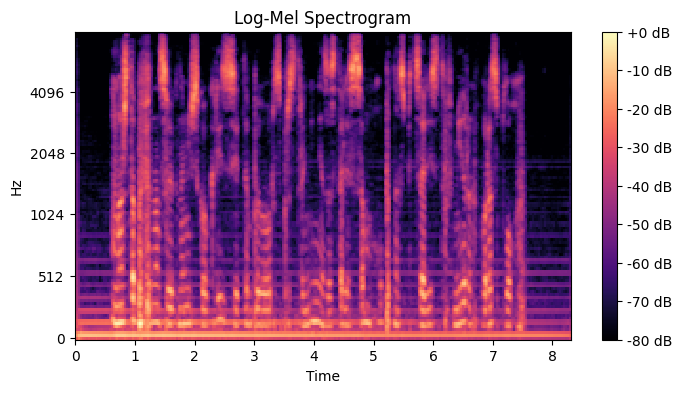

In [133]:
# visualizing log-mel spectrogram
def compute_logmel_spectrogram(y, sr, n_mels=128, hop_length=512):
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=hop_length)
    logmel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return logmel_spectrogram
 
# load the audio file
audio_file_path = 'test_ru_sample.mp3'
target_sr = 16000
 
# Load the audio file
y, sr = librosa.load(audio_file_path, sr=target_sr)
 
# Compute log-mel spectrogram
logmel_spectrogram = compute_logmel_spectrogram(y, sr=sr)
 
# Display the log-mel spectrogram
plt.figure(figsize=(8, 4))
librosa.display.specshow(logmel_spectrogram, sr=sr, hop_length=512, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-Mel Spectrogram')
plt.show()